In [4]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [6]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [7]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [8]:
immune_classes = pd.read_csv(os.getcwd()+'/data/immune_classes.txt', sep = '\t')
immune_classes.rename(columns = {'Unnamed: 0':'t_ind'}, inplace = True)

In [9]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [13]:

covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')
covid_data_North_America  = covid_data[covid_data['location'] == 'North America']

EmptyDataError: No columns to parse from file

In [17]:
last_date = '2022-06-31'
covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')
covid_data_North_America  = covid_data[covid_data['location'] == 'North America'].query(f'date < "{last_date}"')
clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/clade_stats_SARS-CoV-2'
assert os.path.exists(clade_stats_SARS_CoV_2_folder)

clade_statistics_SARS_CoV_2_North_America = pd.read_csv(clade_stats_SARS_CoV_2_folder+'/clade_statistics_North_America.tsv', sep = '\t')
clade_statistics_SARS_CoV_2_North_America = clade_statistics_SARS_CoV_2_North_America.query(f'Time < "{last_date}"')

In [18]:
x_origination_times = []
xmin_vals =[0]+ list(np.logspace(-7,-1,10))
for xmin in tqdm(xmin_vals ):
    x_mini_df  = clade_statistics_SARS_CoV_2_North_America.query(f'Sublineage_Freq > {xmin}').groupby(['Clade'])['Time'].min()
    x_origination_times.append(x_mini_df)

#concatenate with column names time_xmin
x_origination_times = pd.concat(x_origination_times,axis=1)
x_origination_times.columns = [f'time_{xmin:.1e}' for xmin in xmin_vals]

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 25.39it/s]


In [19]:
reference_date = pd.to_datetime('2020-01-01')
x_origination_times.reset_index(inplace=True)

for xmin in xmin_vals:
    x_origination_times[f'Time_datetime_{xmin:.1e}'] = pd.to_datetime(x_origination_times[f'time_{xmin:.1e}'])
    x_origination_times[f'day_diff_{xmin:.1e}'] = x_origination_times[f'Time_datetime_{xmin:.1e}']-reference_date

In [20]:
count_thresh = []
for xmin in xmin_vals:
    dcol = x_origination_times[f'day_diff_{xmin:.1e}']
    print(xmin, dcol[~np.isnan(dcol)].count())
    count_thresh.append(dcol[~np.isnan(dcol)].count())

   

0 3716
1e-07 3537
4.641588833612782e-07 3517
2.1544346900318822e-06 3486
1e-05 3470
4.641588833612772e-05 3384
0.00021544346900318823 1387
0.001 425
0.004641588833612773 84
0.021544346900318822 42
0.1 29


/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_33849/1583344009.py:4: RuntimeWarning: divide by zero encountered in divide
  ax.plot(xmin_vals,1/xmin_vals)


Text(0.5, 0.98, 'Number of clades with frequency above threshold, North_America')

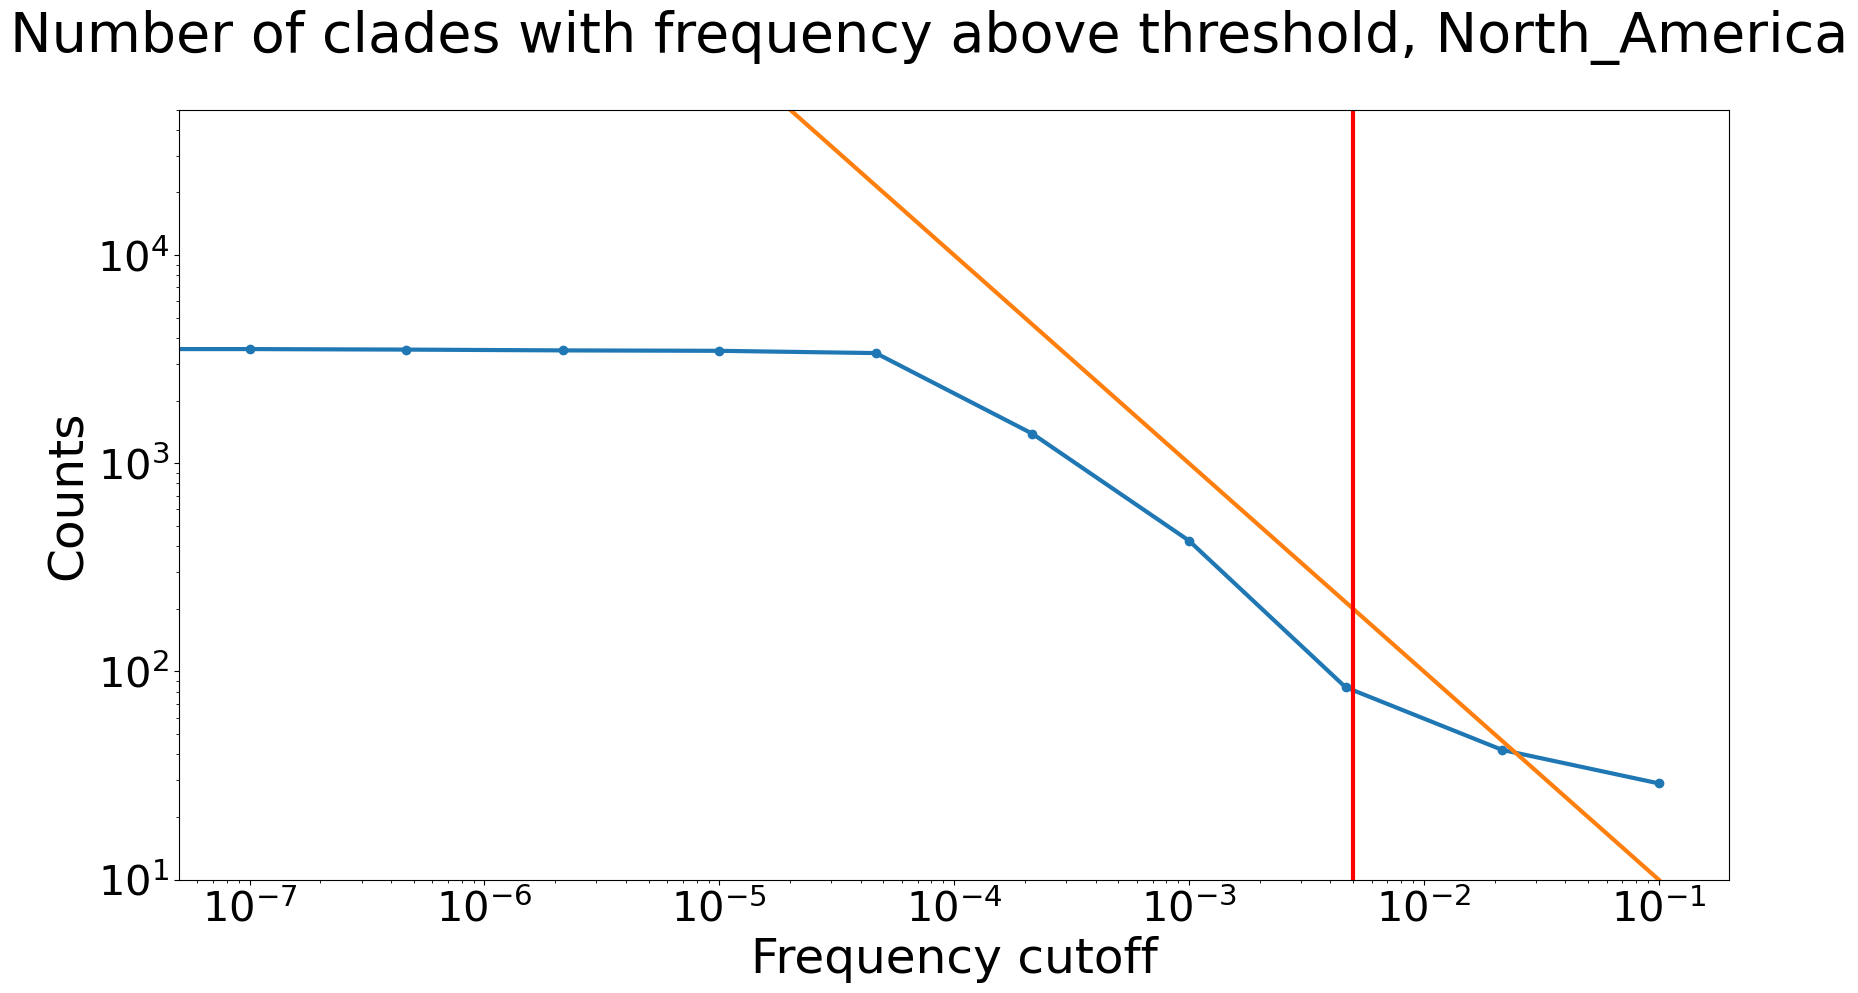

In [21]:
xmin_vals = np.array(xmin_vals)
fig,ax= plt.subplots(1,1,figsize=(20,10))
ax.plot(xmin_vals,count_thresh,marker='o')
ax.plot(xmin_vals,1/xmin_vals)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Frequency cutoff')
ax.set_ylabel('Counts')

ax.set_ylim(bottom=1e1,top=5e4)
ax.axvline(x = 5e-3,color='r')
fig.suptitle('Number of clades with frequency above threshold, North_America')


In [22]:
b,h= np.histogram(x_origination_times['day_diff_0.0e+00'].dt.days,bins = np.arange(0,x_origination_times['day_diff_0.0e+00'].dt.days.max(),7))

In [23]:
North_America_cases = 7*covid_data_North_America['new_cases_smoothed']
North_America_cases = North_America_cases[North_America_cases>0]
North_America_cases = North_America_cases[~np.isinf(North_America_cases)]
North_America_cases = North_America_cases[~np.isnan(North_America_cases)]


covid_data_North_America['Time_datetime'] = pd.to_datetime(covid_data_North_America['date'])
covid_data_North_America['day_diff'] = covid_data_North_America['Time_datetime']-reference_date

covid_data_North_America['day_diff'] = covid_data_North_America['day_diff'].apply(lambda x: x.days)
covid_data_North_America['weekly_new_cases_smoothed'] = covid_data_North_America['new_cases_smoothed']*7

average weekly count: 28.5
average weekly cases: 8.1e+05
weekly mutation rate: 3.5e-05

geometric average weekly count: 15.7
geometric average weekly cases: 3.2e+05
geometric weekly mutation rate: 4.9e-05


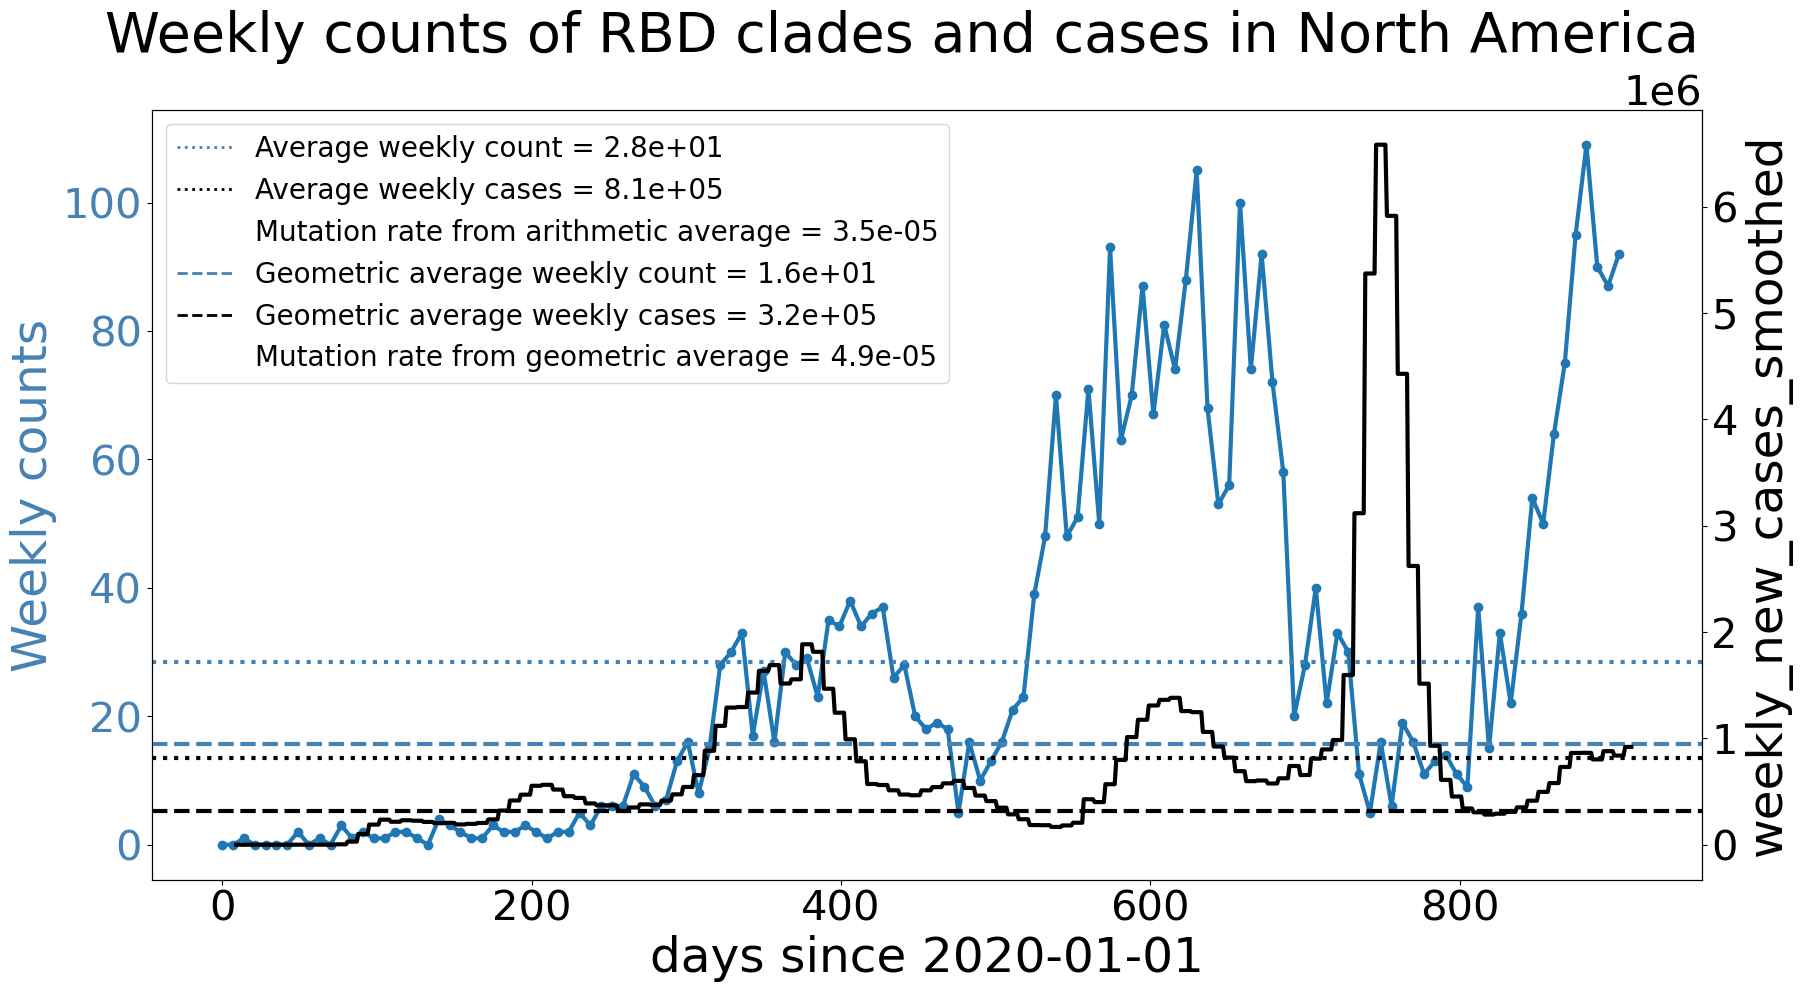

In [27]:
fig,ax= plt.subplots(1,1,figsize=(20,10))

ax.plot(h[:-1],b,marker='o')
geom_avg_weekly_counts = np.exp(np.average(np.log(b[b>0])))
geom_avg_weekly_cases = np.exp(np.average(np.log(North_America_cases)))

lin_avg_weekly_counts = np.average(b)
lin_avg_weekly_cases = np.average(North_America_cases)

ax.axhline(lin_avg_weekly_counts,color='steelblue',ls = ':')
ax.axhline(geom_avg_weekly_counts,color='steelblue',ls = '--')
# for xmin in xmin_vals[1:3:1]:
#     plt.hist(x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,bins = 100,histtype='step',density=True,label = f'{xmin:.1e}',lw=3);

tax= ax.twinx()
sns.lineplot(data = covid_data_North_America, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
tax.set_xlim(ax.get_xlim())

# mpl_axes_aligner.align.yaxes(ax, 0, tax, 0, 0.1)
tax.axhline(lin_avg_weekly_cases,color='black',ls = ':')
tax.axhline(geom_avg_weekly_cases,color='black',ls = '--')
print(f'average weekly count: {lin_avg_weekly_counts:.1f}')
print(f'average weekly cases: {lin_avg_weekly_cases:.1e}')
print(f'weekly mutation rate: {lin_avg_weekly_counts/lin_avg_weekly_cases:.1e}')
print()
print(f'geometric average weekly count: {geom_avg_weekly_counts:.1f}')
print(f'geometric average weekly cases: {geom_avg_weekly_cases:.1e}')
print(f'geometric weekly mutation rate: {geom_avg_weekly_counts/geom_avg_weekly_cases:.1e}')

handles = [
    Line2D([0], [0], color='steelblue', lw=2, ls = ':', label=f'Average weekly count = {lin_avg_weekly_counts:.1e}'),
    Line2D([0], [0], color='black', lw=2, ls = ':', label=f'Average weekly cases = {lin_avg_weekly_cases:.1e}'), 
    Line2D([0], [0], color='steelblue', lw=2, ls = '', label=f'Mutation rate from arithmetic average = {lin_avg_weekly_counts/lin_avg_weekly_cases:.1e}'),
    Line2D([0], [0], color='steelblue', lw=2, ls = '--', label=f'Geometric average weekly count = {geom_avg_weekly_counts:.1e}'),
    Line2D([0], [0], color='black', lw=2, ls = '--', label=f'Geometric average weekly cases = {geom_avg_weekly_cases:.1e}'),
    Line2D([0], [0], color='black', lw=2, ls = '', label=f'Mutation rate from geometric average = {geom_avg_weekly_counts/geom_avg_weekly_cases:.1e}'),]


ax.legend(handles= handles,loc='upper left',fontsize=20)
ax.set_xlabel(f'days since {reference_date.date()}')
ax.set_ylabel('Weekly counts',color='steelblue')
ax.tick_params(axis='y', labelcolor='steelblue')
fig.suptitle('Weekly counts of RBD clades and cases in North America')
plt.savefig(output_folder+'/weekly_counts_North_America.pdf',bbox_inches='tight')
# ax.set_yscale('log')

/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_33849/1934695723.py:6: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(xmin_vals,1/xmin_vals)


average weekly count: 28.5
average weekly cases: 8.1e+05
weekly mutation rate: 3.5e-05

geometric average weekly count: 15.7
geometric average weekly cases: 3.2e+05
geometric weekly mutation rate: 4.9e-05


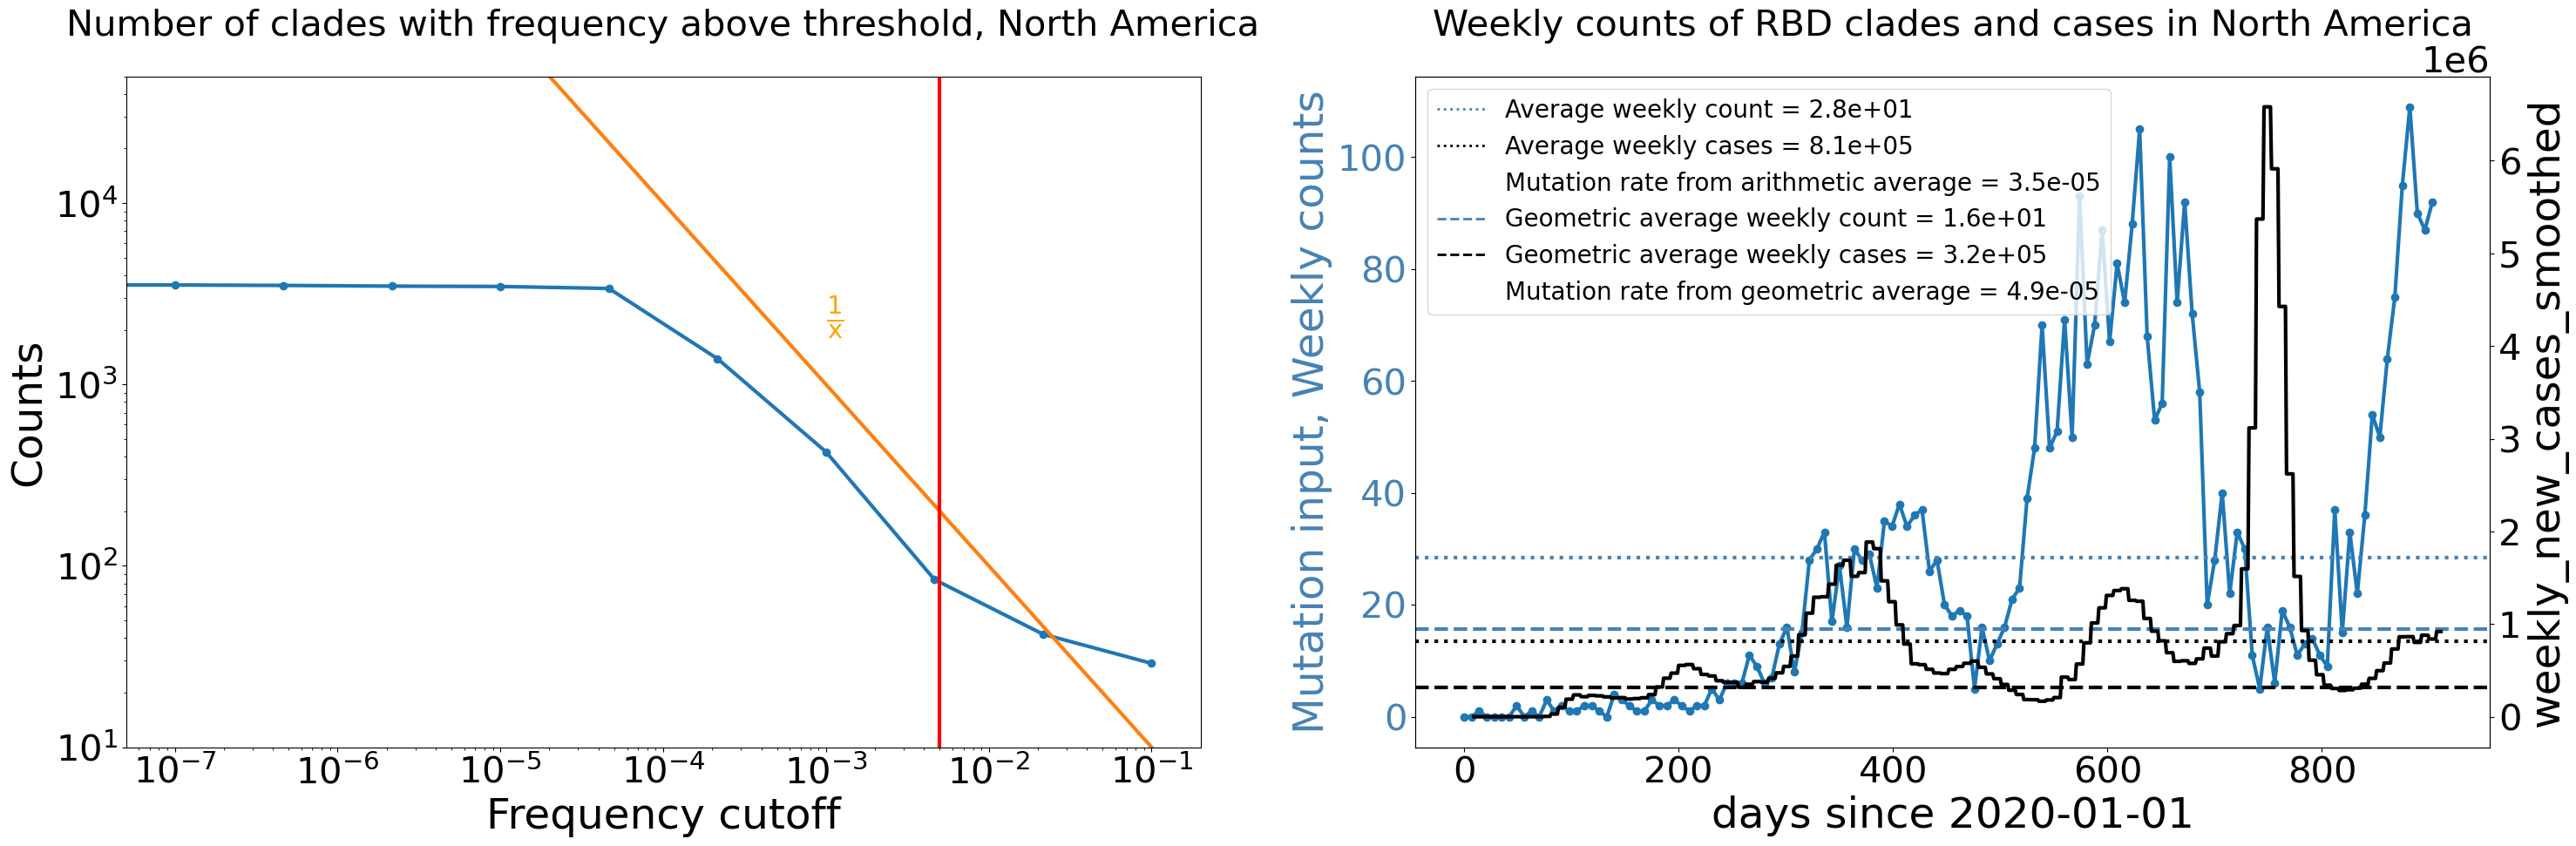

In [29]:
fig,ax= plt.subplots(1,2,figsize=(35,10))

plot_ax0 = True
if plot_ax0:
    ax[0].plot(xmin_vals,count_thresh,marker='o')
    ax[0].plot(xmin_vals,1/xmin_vals)
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].set_xlabel('Frequency cutoff')
    ax[0].set_ylabel('Counts')
    ax[0].annotate(r'$\frac{1}{x}$', xy=(1e-3, 2e3), xytext=(1e-3, 2e3), fontsize=30,color='orange')

    ax[0].set_ylim(bottom=1e1,top=5e4)
    ax[0].axvline(x = 5e-3,color='r')
    ax[0].set_title('Number of clades with frequency above threshold, North America', fontsize = 30, y = 1.05)

plot_ax1 = True
if plot_ax1:
    ax[1].plot(h[:-1],b,marker='o')
    geom_avg_weekly_counts = np.exp(np.average(np.log(b[b>0])))
    geom_avg_weekly_cases = np.exp(np.average(np.log(North_America_cases)))

    lin_avg_weekly_counts = np.average(b)
    lin_avg_weekly_cases = np.average(North_America_cases)

    ax[1].axhline(lin_avg_weekly_counts,color='steelblue',ls = ':')
    ax[1].axhline(geom_avg_weekly_counts,color='steelblue',ls = '--')
    # for xmin in xmin_vals[1:3:1]:
    #     plt.hist(x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,bins = 100,histtype='step',density=True,label = f'{xmin:.1e}',lw=3);

    tax= ax[1].twinx()
    sns.lineplot(data = covid_data_North_America, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
    tax.set_xlim(ax[1].get_xlim())

    # mpl_axes_aligner.align.yaxes(ax[1], 0, tax, 0, 0.1)
    tax.axhline(lin_avg_weekly_cases,color='black',ls = ':')
    tax.axhline(geom_avg_weekly_cases,color='black',ls = '--')
    print(f'average weekly count: {lin_avg_weekly_counts:.1f}')
    print(f'average weekly cases: {lin_avg_weekly_cases:.1e}')
    print(f'weekly mutation rate: {lin_avg_weekly_counts/lin_avg_weekly_cases:.1e}')
    print()
    print(f'geometric average weekly count: {geom_avg_weekly_counts:.1f}')
    print(f'geometric average weekly cases: {geom_avg_weekly_cases:.1e}')
    print(f'geometric weekly mutation rate: {geom_avg_weekly_counts/geom_avg_weekly_cases:.1e}')


    handles = [
        Line2D([0], [0], color='steelblue', lw=2, ls = ':', label=f'Average weekly count = {lin_avg_weekly_counts:.1e}'),
        Line2D([0], [0], color='black', lw=2, ls = ':', label=f'Average weekly cases = {lin_avg_weekly_cases:.1e}'), 
        Line2D([0], [0], color='steelblue', lw=2, ls = '', label=f'Mutation rate from arithmetic average = {lin_avg_weekly_counts/lin_avg_weekly_cases:.1e}'),
        Line2D([0], [0], color='steelblue', lw=2, ls = '--', label=f'Geometric average weekly count = {geom_avg_weekly_counts:.1e}'),
        Line2D([0], [0], color='black', lw=2, ls = '--', label=f'Geometric average weekly cases = {geom_avg_weekly_cases:.1e}'),
        Line2D([0], [0], color='black', lw=2, ls = '', label=f'Mutation rate from geometric average = {geom_avg_weekly_counts/geom_avg_weekly_cases:.1e}'),]



    ax[1].legend(handles= handles,loc='upper left',fontsize=20)
    ax[1].set_xlabel(f'days since {reference_date.date()}')
    ax[1].set_ylabel('Mutation input, Weekly counts',color='steelblue')
    ax[1].tick_params(axis='y', labelcolor='steelblue')
    ax[1].set_title('Weekly counts of RBD clades and cases in North America', fontsize = 30, y = 1.05)
plt.savefig(output_folder+'/weekly_counts_North_America.pdf',bbox_inches='tight')
# ax[1].set_yscale('log')

In [ ]:
from scipy.signal import savgol_filter

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


average weekly count: 0.0
average weekly cases: 8.1e+05
weekly mutation rate: 1.4e-09

geometric average weekly count: 0.0
geometric average weekly cases: 3.2e+05
geometric weekly mutation rate: 1.9e-09


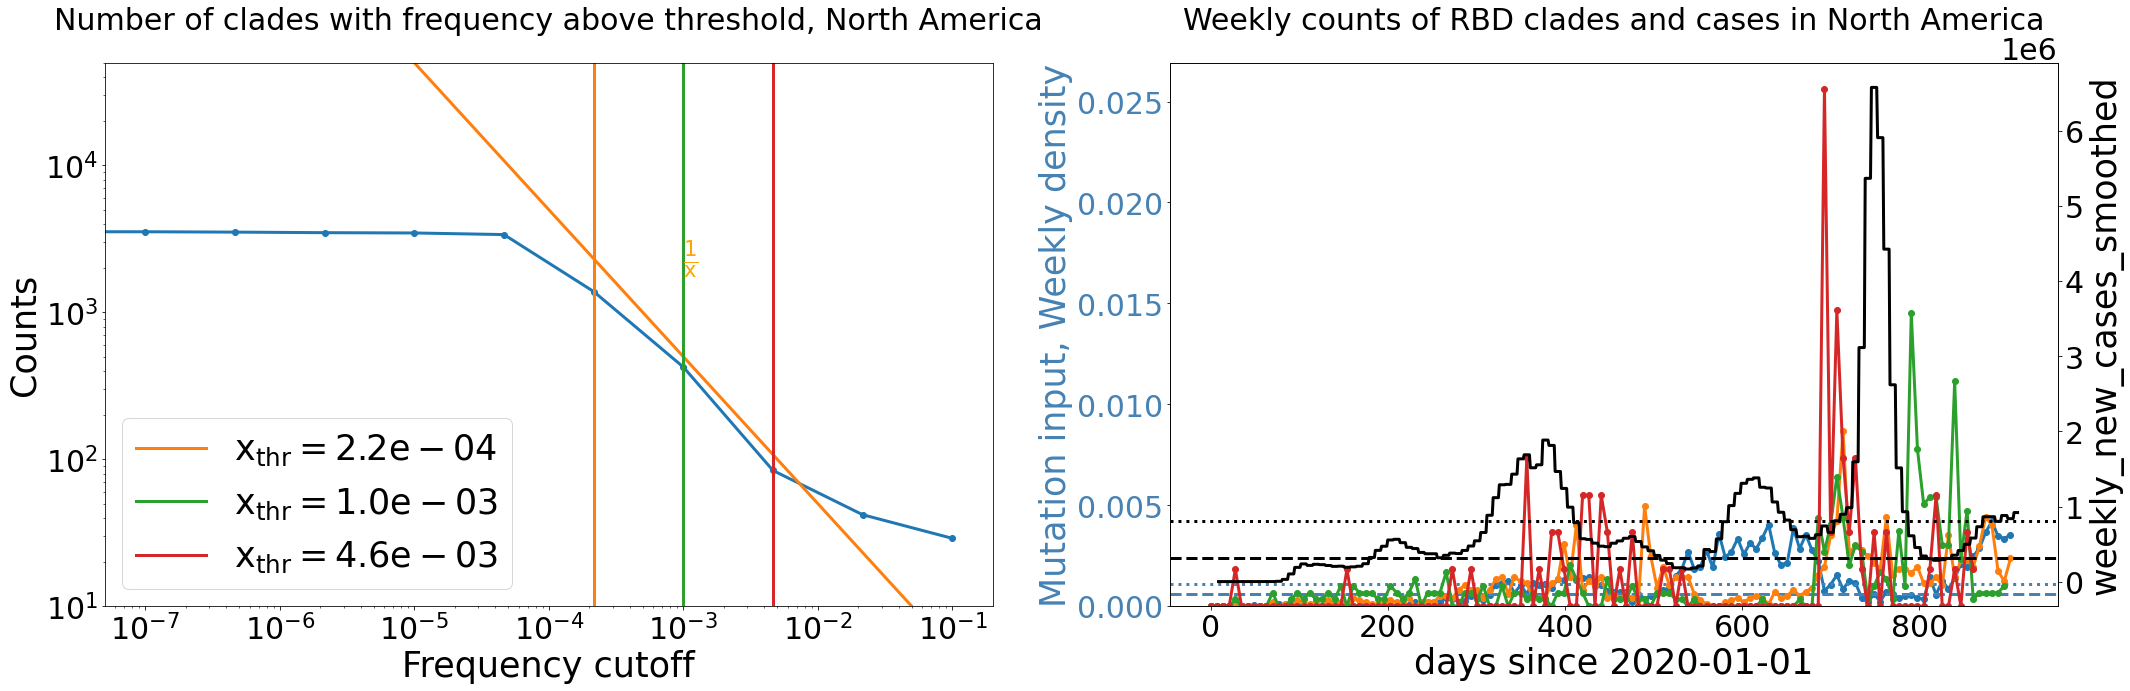

In [ ]:
fig,ax= plt.subplots(1,2,figsize=(35,10))

plot_ax0 = True
if plot_ax0:
    ax[0].plot(xmin_vals,count_thresh,marker='o')
    ax[0].plot(xmin_vals,1/(2*xmin_vals))
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].set_xlabel('Frequency cutoff')
    ax[0].set_ylabel('Counts')
    ax[0].annotate(r'$\frac{1}{x}$', xy=(1e-3, 2e3), xytext=(1e-3, 2e3), fontsize=30,color='orange')

    ax[0].set_ylim(bottom=1e1,top=5e4)
    # ax[0].axvline(x = 5e-3,color='r')
    ax[0].set_title('Number of clades with frequency above threshold, North America', fontsize = 30, y = 1.05)

plot_ax1 = True
if plot_ax1:
    b,h= np.histogram(x_origination_times['day_diff_0.0e+00'].dt.days,bins = np.arange(0,x_origination_times['day_diff_0.0e+00'].dt.days.max(),7),density=True)
    ax[1].plot(h[:-1],b,marker='o')
    geom_avg_weekly_counts = np.exp(np.average(np.log(b[b>0])))
    geom_avg_weekly_cases = np.exp(np.average(np.log(North_America_cases)))

    lin_avg_weekly_counts = np.average(b)
    lin_avg_weekly_cases = np.average(North_America_cases)

    ax[1].axhline(lin_avg_weekly_counts,color='steelblue',ls = ':')
    ax[1].axhline(geom_avg_weekly_counts,color='steelblue',ls = '--')
    for xmin in xmin_vals[6:9]:
        b_xmin,h_xmin = np.histogram(x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,bins = np.arange(0,x_origination_times[f'day_diff_{xmin:.1e}'].dt.days.max(),7),density=True)
        
        b_xmin_smoothed = savgol_filter(b_xmin, 11, 3)
        l_xmin, = ax[1].plot(h_xmin[:-1],b_xmin,marker='o',label = f'{xmin:.1e}')
        ax[0].axvline(x = xmin,color=l_xmin.get_color(), label = fr'$x_\mathrm{{thr}}={xmin:.1e}$')

    tax= ax[1].twinx()
    sns.lineplot(data = covid_data_North_America, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
    tax.set_xlim(ax[1].get_xlim())

    # mpl_axes_aligner.align.yaxes(ax[1], 0, tax, 0, 0.1)
    tax.axhline(lin_avg_weekly_cases,color='black',ls = ':')
    tax.axhline(geom_avg_weekly_cases,color='black',ls = '--')
    print(f'average weekly count: {lin_avg_weekly_counts:.1f}')
    print(f'average weekly cases: {lin_avg_weekly_cases:.1e}')
    print(f'weekly mutation rate: {lin_avg_weekly_counts/lin_avg_weekly_cases:.1e}')
    print()
    print(f'geometric average weekly count: {geom_avg_weekly_counts:.1f}')
    print(f'geometric average weekly cases: {geom_avg_weekly_cases:.1e}')
    print(f'geometric weekly mutation rate: {geom_avg_weekly_counts/geom_avg_weekly_cases:.1e}')


    # handles = [
    #     Line2D([0], [0], color='steelblue', lw=2, ls = ':', label=f'Average weekly count = {lin_avg_weekly_counts:.1e}'),
    #     Line2D([0], [0], color='black', lw=2, ls = ':', label=f'Average weekly cases = {lin_avg_weekly_cases:.1e}'), 
    #     Line2D([0], [0], color='steelblue', lw=2, ls = '', label=f'Mutation rate from arithmetic average = {lin_avg_weekly_counts/lin_avg_weekly_cases:.1e}'),
    #     Line2D([0], [0], color='steelblue', lw=2, ls = '--', label=f'Geometric average weekly count = {geom_avg_weekly_counts:.1e}'),
    #     Line2D([0], [0], color='black', lw=2, ls = '--', label=f'Geometric average weekly cases = {geom_avg_weekly_cases:.1e}'),
    #     Line2D([0], [0], color='black', lw=2, ls = '', label=f'Mutation rate from geometric average = {geom_avg_weekly_counts/geom_avg_weekly_cases:.1e}'),]


    ax[0].legend(loc='best')
    ax[1].set_ylim(bottom=0)
    # ax[1].legend(handles= handles,loc='upper left',fontsize=20)
    ax[1].set_xlabel(f'days since {reference_date.date()}')
    ax[1].set_ylabel('Mutation input, Weekly density',color='steelblue')
    ax[1].tick_params(axis='y', labelcolor='steelblue')
    ax[1].set_title('Weekly counts of RBD clades and cases in North America', fontsize = 30, y = 1.05)
    # ax[1].set_yscale('log')

In [ ]:
from scipy.ndimage import gaussian_filter1d
from scipy.stats import gaussian_kde

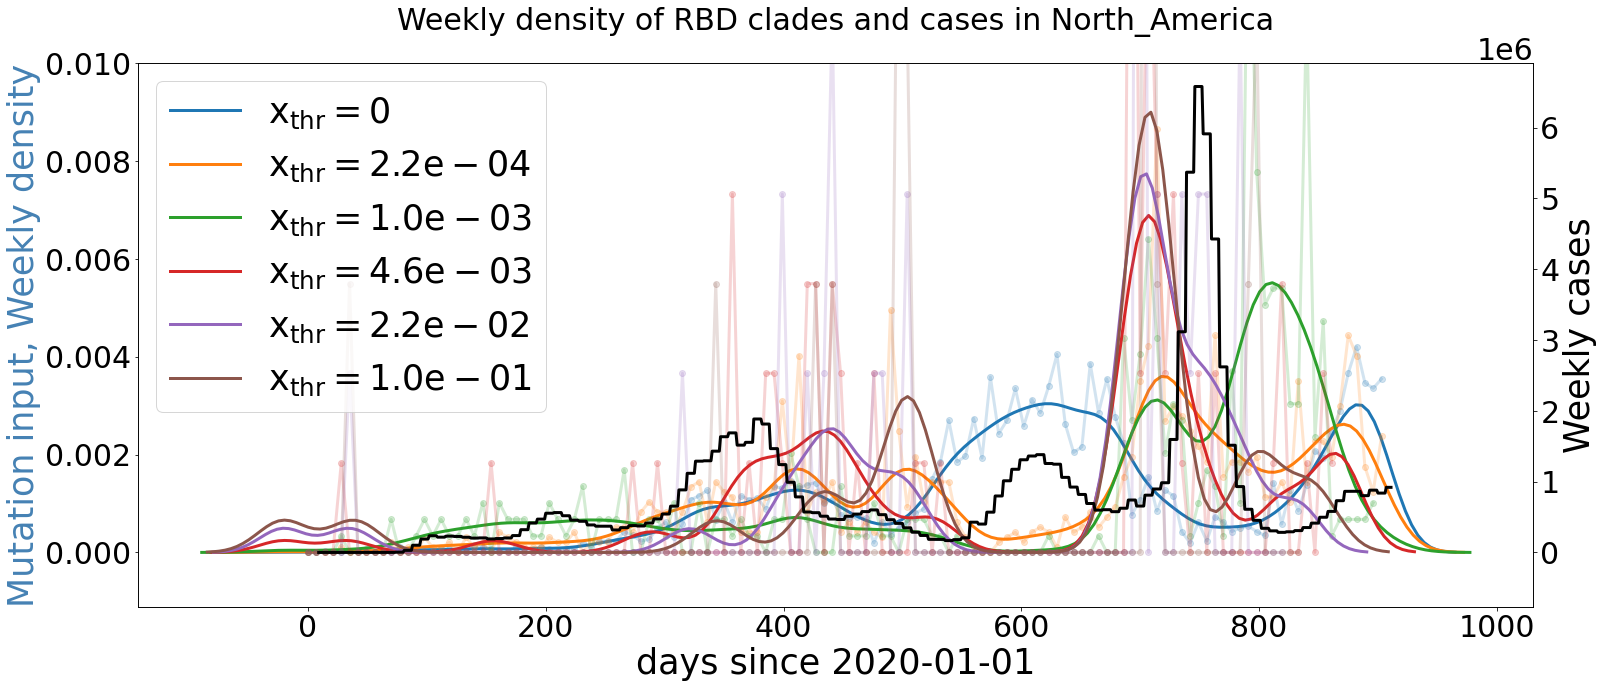

In [ ]:
fig,ax= plt.subplots(figsize=(25,10))

b_0, h_0 = np.histogram(x_origination_times['day_diff_0.0e+00'].dt.days,bins = np.arange(0,x_origination_times['day_diff_0.0e+00'].dt.days.max(),7),density=True)
l_0, = ax.plot(h_0[:-1],b_0, marker='o', alpha=0.2)
sns.kdeplot(x_origination_times['day_diff_0.0e+00'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={0}$',color=l_0.get_color())


for xmin in xmin_vals[6:]:
    b_xmin,h_xmin = np.histogram(x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,bins = np.arange(0,x_origination_times[f'day_diff_{xmin:.1e}'].dt.days.max(),7),density=True)
    l_xmin, = ax.plot(h_xmin[:-1],b_xmin, marker='o',alpha=0.2)
    sns.kdeplot(x_origination_times[f'day_diff_{xmin:.1e}'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={xmin:.1e}$',color=l_xmin.get_color())
    # ax.plot(h_xmin[:-1],b_xmin_smoothed,ls='-',color=l_xmin.get_color())
    # ax[0].axvline(x = xmin,color=l_xmin.get_color(), label = fr'$x_\mathrm{{thr}}={xmin:.1e}$')
ax.set_ylim(0,1e-2)
ax.legend(loc='best')

tax= ax.twinx()
sns.lineplot(data = covid_data_North_America, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
mpl_axes_aligner.align.yaxes(ax, 0, tax, 0, 0.1)

ax.set_xlabel(f'days since {reference_date.date()}')
ax.set_ylabel('Mutation input, Weekly density',color='steelblue')

tax.set_ylabel('Weekly cases',color='black')
ax.set_title('Weekly density of RBD clades and cases in North_America', fontsize = 30, y = 1.05)

plt.savefig(output_folder+'/weekly_density_North_America.pdf',bbox_inches='tight')

In [ ]:
xmin_vals[6:]

array([0.00021544, 0.001     , 0.00464159, 0.02154435, 0.1       ])